# Synthetic dataset generation using RAFT

This recipe will walk you through using a big LLM such as [OpenAI GPT-4o](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models?tabs=python-secure#gpt-4o-and-gpt-4-turbo) or [Meta Llama 3.1 405B](https://aka.ms/c/model/Meta-Llama-3.1-405B-Instruct) deployed on Azure AI to generate a synthetic dataset using UC Berkeley's Gorilla project RAFT method (see [blog post](https://aka.ms/raft-blog)).

## Overview
![](./doc/raft-process-gen.png)

## What is RAFT?

RAFT stands for Retrieval Augmented Fine Tuning. The general principle is to use a big LLM such as Llama 3.1 405B to analyse a set of documents and generate a dataset of questions and answers that users might want to ask about those documents. We can then use that QA dataset to fine tune a smaller model such as Llama 3.1 8B. The fine tune model will therefore be better at answering questions about those documents.

### Analogy: How to prepare a LLM for an Exam? 📝

*Note: This description was copied from the [UC Berkeley RAFT blog post](https://aka.ms/raft-blog-ucb).*

RAFT is a general recipe to finetune a pretrained LLM to your domain-specific RAG settings. This is a common scenario where you want your LLM to answer questions grounded on a set of documents, for e.g., private files in an enterprise. Such a setting is different from the general RAG where the LLM does not know which domain (of documents) it will be tested on. To better illustrate this setting, let's draw an analogy between deploying and using an LLM with the real-world setting of prepararing for an exam.

![RAFT Open book principle](./doc/raft_openbook.png "RAFT Open book principle")

#### Closed-Book Exam

A closed book exam often refers to the scenario where the LLMs do not have access to any additional documents or references to answer the questions during the exam. For LLMs, this is equivalent to the scenario, for example, in which the LLM is used as a chatbot. In this scenario the LLM draws from the knowledge baked in during pre-training and supervised-finetuning to respond to the users' prompt.

#### Open-Book Exam

In contrast, we liken the open-book exam setting to the scenario in which the LLM can refer to external sources of information (e.g., a website or a book chapter). In such scenarios, typically, the LLM is paired with retriever which retrieves k documents (or specific segments of the document) which are appended to the users' prompt. It is only through these documents retrieved that the LLM gains access to new knowledge. As a result, we argue that the LLM's performance in these settings, where it is trained as a general-purpose LLM is largely dependent on the quality of the retriever and how accurately the retriever can identify the most relevant piece of information.

#### RAFT

RAFT focuses on a narrower but increasingly popular domain than the general open book exam, called the domain-specific open-book exam. In domain-specific open book exam, we know a priori the domain in which the LLM will be tested --- used for inference. The LLM can respond to the users' prompt using use any and all information from this specific domain, which it has been fine-tuned on. Examples of domain specific examples include enterprise documents, latest news, code repositories belonging to an organization, etc. In all these scenarios, the LLM will be used to respond to the questions, whose answers can be found within a collection of documents (a small practical domain). The retrieval technique itself has little to no-impact on the mechanism (though it may impact the accuracy). This paper mainly studies this, domain-specific open-book setting and how to adapt a pretrained LLM to this specific domain, including how to make it more robust to a varying number of retrieved documents and distractors.

### RAFT Process: from domain documents to Q/A/CoT dataset splits

The process is the following. RAFT takes as input a set of documents, split them into chunks, and for each chunk generates a list of questions, Chain Of Thought answers with a selection of relevant and irrelevant context chunks.

![RAFT](./doc/raft.png "RAFT")

## Running time and cost

The RAFT script usually takes a few minutes on the default sample document but can take days on bigger domains depending on the number and size of documents and the number of questions being generated for each chunk.

The cost of running this RAFT script on the sample document should be a few dollars. But beware, running it on bigger domains can cost hundreds of dollars if not more. It is safe to run this notebook multiple times though as the costly part, running the `raft.py` script, will only be executed if the dataset doesn't exist yet.

## Pre-requisites

Before running this notebook, let's make sure your environment is ready

### 1. Deploy Meta Llama 3.1 405B Instruct as a serverless endpoint.

This model will be used to generate the synthetic dataset.

You can either use [Azure ML Studio](https://aka.ms/raft-llama-31-learn-deploy-405b) or [Azure AI Studio](https://aka.ms/raft-llama-31-learn-deploy-405b-ai-studio).

**Note**: an Azure ML Workspace is the same as a Azure AI Hub, you will be able to go back and forth between the two transparently.

### 2. Deploy OpenAI's `text-embedding-ada-002` as a serverless endpoint.

This model will be used to create the chunk embeddings.

You can follow the same procedure as for the Meta Llama model deployment

### 3. Setup your environment variables

Copy the `.env.sample` file to `.env` and update according to your Azure AI project configuration and deployed endpoints

## Setup the RAFT repository
 
This script will checkout a shallow and narrow clone of the UC Berkeley Gorilla RAFT repository locally so that this notebook can invoke the RAFT script and util functions. It can safely be run multiple times.

In [14]:
! ./setup_raft.sh

Setup Gorilla RAFT in /workspaces/llama-raft-recipe/.gorilla
Your branch is up to date with 'origin/raft-distillation-recipe'.
Already up to date.


## Install requirements

The requirements should have been automatically installed if you opened the project in Dev Container or Codespaces, but if not, uncomment the following cell to install the requirements

In [15]:
#! pip install -r requirements.txt

## Check instrastructure requirements

The following integration tests check that the endpoints are accessible and working before executing the RAFT program

In [16]:
! python -m pytest --rootdir=infra/tests/

============================= test session starts ==============================
platform linux -- Python 3.12.8, pytest-8.1.2, pluggy-1.6.0
rootdir: /workspaces/llama-raft-recipe/infra/tests
configfile: ../../pyproject.toml
plugins: anyio-4.9.0, langsmith-0.4.6
collected 4 items                                                              

infra/tests/test_baseline.py .                                           [ 25%]
infra/tests/test_embeddings.py .                                         [ 50%]
infra/tests/test_scoring.py .                                            [ 75%]
infra/tests/test_teacher.py .                                            [100%]

=============================== warnings summary ===============================
test_baseline.py: 3 warnings
test_embeddings.py: 3 warnings
test_scoring.py: 3 warnings
test_teacher.py: 3 warnings
  /usr/local/lib/python3.12/site-packages/msal/token_cache.py:182: DeprecationWarning: Use list(search(...)) instead to explicitly get a l

## Load infrastructure environnment variables

In [17]:
from os import getenv
from dotenv import load_dotenv

# Variables passed by previous notebooks
load_dotenv(".env.state")
load_dotenv(".env")

EMBEDDING_OPENAI_DEPLOYMENT=getenv("EMBEDDING_OPENAI_DEPLOYMENT")
TEACHER_OPENAI_DEPLOYMENT=getenv("TEACHER_OPENAI_DEPLOYMENT")

print(f"Using embedding model {EMBEDDING_OPENAI_DEPLOYMENT}")
print(f"Using teacher model {TEACHER_OPENAI_DEPLOYMENT}")

Using embedding model None
Using teacher model None


## Select the documents

#### Notebook parameters

*Note: Parameters are typed as indicated for Papermill introspection*

In [18]:
ds_name: str = "surfing"
doc_path: str = "sample_data/surfing/Surfing - Wikipedia.pdf"
format: str = "chat"
finetuning_train_split : int = .8
finetuning_valid_split : int = .1
finetuning_threshold : int = 65
raft_questions: int = 2

In [19]:
import pandas as pd
from utils import update_state

ds_path = f"dataset/{ds_name}"
ds_output_file = f"{ds_path}.jsonl"
update_state("DATASET_NAME", ds_name)
print("Creating dataset: " + ds_name)

Updating state file with DATASET_NAME=surfing
Creating dataset: surfing


In [20]:
! mkdir -p $ds_path

### Overview of PDF

   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBo

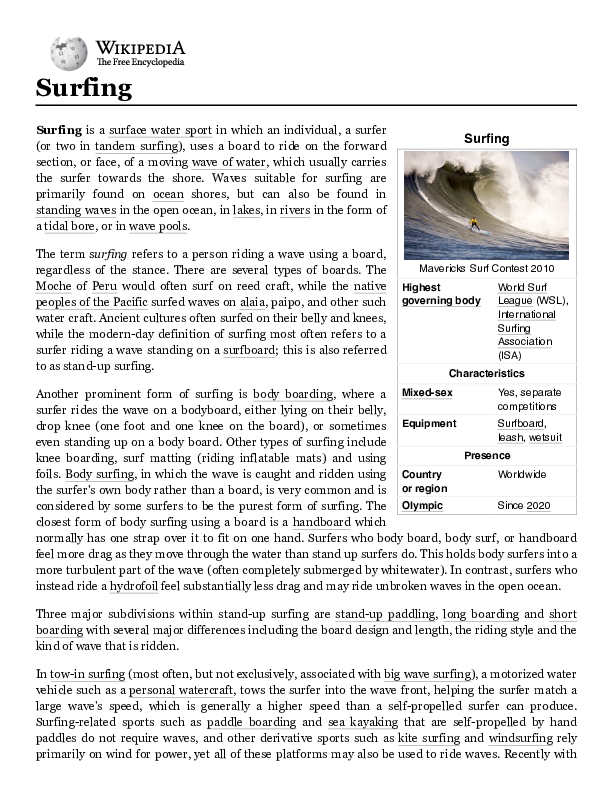

In [21]:
from utils import get_pdf_image
from pathlib import Path

pdf_image = None
if Path(doc_path).exists() and Path(doc_path).is_file() and Path(doc_path).suffix == ".pdf":
    pdf_image = get_pdf_image(doc_path)
pdf_image

### Generate Q/A/CoT fine-tuning dataset using RAFT from the domain specific documents

The `--completion_model` and `--embedding_model` parameters refer to the names of the deployments of the models in Azure.

**Note about `--qa-threshold`**: The Azure AI Finetuning service requires a minimum of 65 samples in the training split so in order to make this notebook run as quickly as possible with a demo dataset, we calculate the minimum number of samples we need to generate overall using the `finetuning_threshold` and the `finetuning_train_split`.

In [22]:
from math import ceil
qa_threshold = ceil(finetuning_threshold / finetuning_train_split)
print(f"QA threshold: {qa_threshold}")

QA threshold: 82


In [23]:
! env $(cat .env .env.state) python3 .gorilla/raft/raft.py \
    --datapath "$doc_path" \
    --output $ds_path \
    --distractors 3 \
    --doctype pdf \
    --chunk_size 512 \
    --questions $raft_questions \
    --workers 2 \
    --system-prompt-key llama \
    --completion_model $TEACHER_OPENAI_DEPLOYMENT \
    --embedding_model $EMBEDDING_OPENAI_DEPLOYMENT \
    --qa-threshold $qa_threshold \
    --completion-env-prefix TEACHER

cat: .env: No such file or directory
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
2025-07-18 02:39:22  INFO [  0%] env_config Resolved OpenAI env vars with 'TEACHER' prefix:
2025-07-18 02:39:22  INFO [  0%] env_config  - AZURE_OPENAI_ENDPOINT=https://aoai-3wqa4qz-cvi-raft-aitour26-41.openai.azure.com/
2025-07-18 02:39:22  INFO [  0%] env_config  - OPENAI_API_VERSION=2023-07-01-preview
2025-07-18 02:39:22  INFO [  0%] env_config  - AZURE_OPENAI_DEPLOYMENT=openai-gpt-4-1
2025-07-18 02:39:22  INFO [  0%] client_utils Using Azure OpenAI Default Azure Credential Keyless authentication
2025-07-18 02:39:22  INFO [  0%] azure.identity._credentials.environment No environment configuration found.
2025-07-18 02:39:22  INFO [  0%] azure.identity._credentials.managed_identity ManagedIdentityCredential will use IMDS
2025-07-18 02:39:22  INFO [  0%] raft Using checkpoint chunks /workspace

*Note*: The bit of shell logic wrapping the python script call allows to skip the generation if the dataset has already been generated so it is safe to run this notebook multiple times.

## Prepare training, validation and evaluation splits

Let's define variables for the different files we will need throughout this notebook

In [24]:
raft_arrow_file = f"{ds_path}/data-00000-of-00001.arrow"
dataset_path = f"{ds_path}-files/{ds_name}-full.jsonl"
dataset_path_hf = f"{ds_path}-files/{ds_name}-hf.full.jsonl"

dataset_path_hf_train = f"{ds_path}-files/{ds_name}-hf.train.jsonl"
dataset_path_hf_valid = f"{ds_path}-files/{ds_name}-hf.valid.jsonl"
dataset_path_hf_eval = f"{ds_path}-files/{ds_name}-hf.eval.jsonl"

dataset_path_ft_train = f"{ds_path}-files/{ds_name}-ft.train.jsonl"
dataset_path_ft_valid = f"{ds_path}-files/{ds_name}-ft.valid.jsonl"

print(f"Reading arrow file {raft_arrow_file}")

Reading arrow file dataset/surfing/data-00000-of-00001.arrow


### Export dataset to JSONL

Let's export the Apache Arrow format file to JSONL, easier to manipulate

In [25]:
! python .gorilla/raft/format.py \
    --input $raft_arrow_file \
    --output $dataset_path_hf \
    --output-format hf

Generating train split: 82 examples [00:00, 9341.94 examples/s]
2025-07-18 02:39:31  INFO [    ] raft Dataset has 82 rows
2025-07-18 02:39:31  INFO [    ] raft Converting arrow file dataset/surfing/data-00000-of-00001.arrow to jsonl hf file dataset/surfing-files/surfing-hf.full.jsonl
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 141.42ba/s]


In [26]:
hf_full_df = pd.read_json(dataset_path_hf, lines=True)
hf_full_df.head(5)

,id,type,question,context,oracle_context,cot_answer,instruction
0,4304cd32-dcce-4075-9682-879aae3c76e0,general,Who can be endangered by these currents?,"{'sentences': [['In addition, The World Surf L...",Under thewrong circumstances these currents ca...,"To answer the question ""Who can be endangered ...","<DOCUMENT>In addition, The World Surf League (..."
1,5ab0ac3c-97e5-4dcd-8a1f-929cc8078981,general,Can both experienced and inexperienced surfers...,{'sentences': [['Under thewrong circumstances ...,Under thewrong circumstances these currents ca...,"To answer the question, we need to determine w...",<DOCUMENT>Under thewrong circumstances these c...
2,df561076-be39-47cf-b8f0-52fbbb2fbb5d,general,What causes the waves to refract near the jett...,{'sentences': [['Othernames for the tube inclu...,"The surf waves happen north ofthe jetty, are l...","To answer the question ""What causes the waves ...","<DOCUMENT>Othernames for the tube include ""the..."
3,8ecde8f3-7f77-4250-9d8e-24d930a41600,general,What is an example of a type 2 jetty?,{'sentences': [['Under thewrong circumstances ...,"The surf waves happen north ofthe jetty, are l...","To answer the question, we need to identify an...",<DOCUMENT>Under thewrong circumstances these c...
4,a04174aa-ea85-42b1-ab28-98de915418a3,general,What is the meaning of the name Johns?,"{'sentences': [['Johns.', 'Wind forces waves t...",Johns.,"To answer the question ""What is the meaning of...",<DOCUMENT>Johns.</DOCUMENT>\n<DOCUMENT>Wind fo...


## Let's look at a sample

In [27]:
from IPython.display import display, Markdown
from random import randint

sample_idx = 2#randint(0, len(hf_full_df) - 1)
sample = hf_full_df.iloc[sample_idx]
instruction_md = sample.instruction.replace("<DOCUMENT>", "`<DOCUMENT>`").replace("</DOCUMENT>", "`</DOCUMENT>`")
oracle_context_md = sample.oracle_context.replace("<DOCUMENT>", "`<DOCUMENT>`").replace("</DOCUMENT>", "`</DOCUMENT>`")
sample_answer_md = sample.cot_answer.replace("<ANSWER>", "`<ANSWER>`").replace("##begin_quote##", "`##begin_quote##`").replace("##end_quote##", "`##end_quote##`")
display(Markdown(f"""
## Oracle Context
{oracle_context_md}

## Question
{sample.question}

## CoT Answer
{sample_answer_md}
"""))


## Oracle Context
The surf waves happen north ofthe jetty, are longer waves, and are powerful. The bathymetry of the sea bottom in Mission Bay has awedge shape formation that causes the waves to refract as they become closer to the jetty.[53] Thewaves converge constructively after they refract and increase the sizes of the waves.A type 2 jetty occurs in an ebb-tidal delta, a delta transitioning between high and low tide. This areahas shallow water, refraction, and distinctive seabed shapes that create large wave heights.[53]An example of a type 2 jetty is called "The Poles" in Atlantic Beach, Florida.

## Question
What causes the waves to refract near the jetty in Mission Bay?  

## CoT Answer
To answer the question "What causes the waves to refract near the jetty in Mission Bay?", we need to identify the specific factor or feature mentioned in the context that leads to the refraction of waves as they approach the jetty.

First, let's look for any mention of wave refraction and what causes it in the context. The context states: `##begin_quote##`The bathymetry of the sea bottom in Mission Bay has a wedge shape formation that causes the waves to refract as they become closer to the jetty.[53]`##end_quote##`.

This sentence directly links the refraction of waves to the "wedge shape formation" of the sea bottom, which is a feature of the bathymetry (the underwater topography) in Mission Bay. The context further discusses the effects of this refraction, such as the convergence and increase in wave size, but the cause of the refraction itself is clearly attributed to the wedge-shaped sea bottom.

Other parts of the context discuss the type of jetty and the general characteristics of the area, but the most meaningful part for this question is the sentence quoted above, as it directly answers what causes the refraction.

In summary, the context explicitly states that the wedge shape formation of the sea bottom (bathymetry) near the jetty is what causes the waves to refract.

`<ANSWER>`: The wedge shape formation of the sea bottom (bathymetry)


### Split the dataset into train / validation / evaluation

In machine learning, splitting a dataset into training, validation, and test sets is a fundamental step to ensure that your model is trained effectively, evaluated properly, and generalizes well to new data. Here’s a brief explanation of each split:

- **Training Split**: The training set (80% of the data) is used to train the model. It helps the model learn patterns and relationships by adjusting its internal parameters based on input-output pairs.

- **Validation Split**: The validation set (10%) is used during training to monitor the model’s performance and guide convergence. It helps fine-tune hyperparameters and ensures the model doesn’t overfit by providing feedback on unseen data during training.

- **Evaluation Split (sometimes also called test split)**: The test set (10%) is used only after training is complete to evaluate the model’s final performance. It provides an unbiased measure of how well the model generalizes to new, unseen data.

In [28]:
# split dataset into 80%/10%/10%
import numpy as np

samples_count = len(hf_full_df)
splits = [int(finetuning_train_split * samples_count), int((finetuning_train_split + finetuning_valid_split) * samples_count)]
print(f"Splitting dataset at {splits}")
hf_train_df, hf_valid_df, hf_eval_df = np.split(hf_full_df, splits)
hf_train_df.to_json(dataset_path_hf_train, orient="records", lines=True)
hf_valid_df.to_json(dataset_path_hf_valid, orient="records", lines=True)
hf_eval_df.to_json(dataset_path_hf_eval, orient="records", lines=True)

Splitting dataset at [65, 73]


/usr/local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Export training and validation splits into JSONL format

In [29]:
! python .gorilla/raft/format.py \
    --input $dataset_path_hf_train \
    --input-type jsonl \
    --output $dataset_path_ft_train \
    --output-format $format \
    --output-completion-prompt-column text\
    --output-completion-completion-column ground_truth

Generating train split: 65 examples [00:00, 5077.66 examples/s]
2025-07-18 02:39:32  INFO [    ] raft Dataset has 65 rows
2025-07-18 02:39:32  INFO [    ] raft Converting jsonl file dataset/surfing-files/surfing-hf.train.jsonl to jsonl chat file dataset/surfing-files/surfing-ft.train.jsonl
Creating json from Arrow format: 100%|███████████| 1/1 [00:00<00:00, 332.88ba/s]


In [30]:
! python .gorilla/raft/format.py \
    --input $dataset_path_hf_valid \
    --input-type jsonl \
    --output $dataset_path_ft_valid \
    --output-format $format \
    --output-completion-prompt-column text\
    --output-completion-completion-column ground_truth

Generating train split: 8 examples [00:00, 422.69 examples/s]
2025-07-18 02:39:33  INFO [    ] raft Dataset has 8 rows
2025-07-18 02:39:33  INFO [    ] raft Converting jsonl file dataset/surfing-files/surfing-hf.valid.jsonl to jsonl chat file dataset/surfing-files/surfing-ft.valid.jsonl
Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1051.73ba/s]


In [31]:
dataset_path_ft_valid_df = pd.read_json(dataset_path_ft_valid, lines=True)
dataset_path_ft_valid_df.head(2)

,messages
0,[{'content': 'The following is a conversation ...
1,[{'content': 'The following is a conversation ...


### Keep the evaluation split aside

We don't need to format the evaluation dataset for now

In [32]:
pd.read_json(dataset_path_hf_eval, lines=True).head(2)

,id,type,question,context,oracle_context,cot_answer,instruction
0,6424faf1-1a20-43b1-9d4e-8241b60abd59,general,What does the surfer do to begin standup surfing?,{'sentences': [['Because of the velocity of th...,"Because of the velocity of the rushing water,t...","To answer the question ""What does the surfer d...",<DOCUMENT>Because of the velocity of the rushi...
1,1949c6f0-aeb9-4890-ac11-b1c3149e4b7d,general,What do surfers wear in cold water?,{'sentences': [['Since a rip current appears t...,"In warmerclimates, swimsuits, surf trunks or b...","To answer the question ""What do surfers wear i...",<DOCUMENT>Since a rip current appears to be an...


## Next step -> Fine-tuning

- [./2_finetune_oai.ipynb](./2_finetune_oai.ipynb) if fine-tuning an **OpenAI** student model such as GPT-4o-mini
- [./2_finetune.ipynb](./2_finetune.ipynb) if fine-tuning an **Azure MaaS** student model such as Llama